In [162]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from numpy.random import seed

In [163]:
os.listdir()

['.ipynb_checkpoints',
 'olist.ipynb',
 'olist_public_dataset_v2.csv',
 'prediction_plot.jpg']

In [164]:
df = pd.read_csv('olist_public_dataset_v2.csv', parse_dates=['order_purchase_timestamp', 'order_aproved_at',\
                                                             'order_estimated_delivery_date','order_delivered_customer_date', \
                                                             'review_creation_date','review_answer_timestamp'])

In [165]:
print(df.shape)
df.head()

(100000, 25)


,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15,2017-02-06 11:04:24.154259,...,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07,2017-02-09 02:37:37
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02,2017-09-13 20:17:41.296915,...,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14,2017-09-15 03:43:47
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07,2017-02-06 15:43:04.758566,...,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,NaN,produto veio antes do prazo informado muito ob...,2017-02-07,2017-02-10 14:18:53
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03,2018-04-03 20:36:43.778451,...,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,NaN,NaN,2018-04-04,2018-04-05 02:52:31
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24,2017-05-04 18:47:45.721758,...,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,NaN,NaN,2017-05-05,2017-05-08 15:20:18


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
order_id                         100000 non-null object
order_status                     100000 non-null object
order_products_value             100000 non-null float64
order_freight_value              100000 non-null float64
order_items_qty                  100000 non-null int64
order_sellers_qty                100000 non-null int64
order_purchase_timestamp         100000 non-null datetime64[ns]
order_aproved_at                 99982 non-null datetime64[ns]
order_estimated_delivery_date    100000 non-null datetime64[ns]
order_delivered_customer_date    97595 non-null datetime64[ns]
customer_id                      100000 non-null object
customer_city                    100000 non-null object
customer_state                   100000 non-null object
customer_zip_code_prefix         100000 non-null int64
product_category_name            100000 non-null object
product_name_lenght  

In [167]:
#Null value verification
df.isna().sum()

order_id                             0
order_status                         0
order_products_value                 0
order_freight_value                  0
order_items_qty                      0
order_sellers_qty                    0
order_purchase_timestamp             0
order_aproved_at                    18
order_estimated_delivery_date        0
order_delivered_customer_date     2405
customer_id                          0
customer_city                        0
customer_state                       0
customer_zip_code_prefix             0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty                   0
product_id                           0
review_id                            0
review_score                         0
review_comment_title             91738
review_comment_message           57511
review_creation_date                 0
review_answer_timestamp              0
dtype: int64

In [168]:
#2 features review_comment_title and review_comment_message have majority of NULL values. Lets drop them
df = df.drop(labels=['review_comment_title','review_comment_message'],axis=1)

In [169]:
#There are 2405 orders for which customer deliver date is Null. Let's find the order status for these records
df[df['order_delivered_customer_date'].isna()].groupby(by=['order_status']).size()

order_status
approved          2
canceled        477
delivered         4
invoiced        331
processing      392
shipped        1190
unavailable       9
dtype: int64

In [170]:
#Based on the order status these orders have not reached the customer yet. 
#Let's ignore these records for forecasting the products_value
df.dropna(subset=['order_delivered_customer_date'],inplace=True)
print(df.shape)

(97595, 23)


In [171]:
#So now there should be records only for order_status 'delivered'. But there are few cancelled orders. 
#The orders might got delivered to customer and then cancelled or might be erroneous data. Lets ignore them too

print(df.groupby(by='order_status').size())
df = df[df['order_status']!='canceled']
print(df.shape)

order_status
canceled         9
delivered    97586
dtype: int64
(97586, 23)


In [172]:
#Let's check for columns which have only unique values
df.nunique()

order_id                         93908
order_status                         1
order_products_value              5950
order_freight_value               7549
order_items_qty                     15
order_sellers_qty                   15
order_purchase_timestamp         93374
order_aproved_at                 93885
order_estimated_delivery_date      474
order_delivered_customer_date    93906
customer_id                      93908
customer_city                     4104
customer_state                      27
customer_zip_code_prefix           851
product_category_name               71
product_name_lenght                 63
product_description_lenght        2709
product_photos_qty                  18
product_id                       23804
review_id                        93908
review_score                         5
review_creation_date               660
review_answer_timestamp          93564
dtype: int64

In [173]:
#Lets remove order_status field alone
df = df.drop(labels=['order_status'],axis=1)

In [174]:
#Let's analyze date fields
for fields in df.columns:
    if df[fields].dtype == 'datetime64[ns]':
        #df[fields] = df[fields].apply(lambda x: x.date())
        print('Range of values for',fields,' ', df[fields].min(), ',',df[fields].max())

Range of values for order_purchase_timestamp   2016-09-05 00:15:33 , 2018-09-28 10:54:31
Range of values for order_aproved_at   2016-09-15 12:16:38 , 2018-09-28 11:05:22.374345
Range of values for order_estimated_delivery_date   2016-10-04 00:00:00 , 2018-12-13 00:00:00
Range of values for order_delivered_customer_date   2016-10-11 13:46:32.082168 , 2018-10-03 03:46:34.717514
Range of values for review_creation_date   2016-10-06 00:00:00 , 2018-10-03 00:00:00
Range of values for review_answer_timestamp   2016-10-07 21:32:28 , 2018-10-03 12:54:08


In [175]:
#Little bit of feature engineering.Converting few datetime fields to days (integer value)
#order estimated days - Estimated No.of days for product delivery from date of purchase.
#order delivered days - Actual No.of days for product delivery
#review answer days - No.of days it took to respond for a review

df['order_estimated_days']= (df['order_estimated_delivery_date']-df['order_purchase_timestamp']).dt.days
df['order_delivered_days'] = (df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days
df['review_answer_days'] = (df['review_answer_timestamp']-df['review_creation_date']).dt.days

In [176]:
#Dropping other date fields now

df = df.drop(labels=['order_aproved_at','order_estimated_delivery_date','order_delivered_customer_date','review_creation_date','review_answer_timestamp'],axis=1)
print(df.shape)

(97586, 20)


In [177]:
#We are going to forecast order_products_value based on order_purchase_timestamp. 
#Lets ignore the id columns which doesnt help out our forecasting

df = df.drop(labels=['order_id','customer_id','product_id','review_id'],axis=1)
print(df.shape)

(97586, 16)


In [178]:
df.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,customer_city,customer_state,customer_zip_code_prefix,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_score,order_estimated_days,order_delivered_days,review_answer_days
0,349.90,13.84,1,1,2017-01-31 17:19:01,Guaratuba,PR,832,beleza_saude,51,625,1,5,42,5,2
1,15.00,15.10,1,1,2017-09-09 19:52:54,Uberlandia,MG,384,informatica_acessorios,44,1428,2,5,22,4,1
2,238.90,18.00,1,1,2017-01-30 17:00:09,Itapevi,SP,66,automotivo,55,637,1,5,35,6,3
3,29.99,18.23,1,1,2018-03-11 18:18:36,Goiania,GO,743,cama_mesa_banho,55,617,1,4,22,23,1
4,295.99,47.65,1,1,2017-04-20 08:01:08,Recife,PE,511,moveis_decoracao,49,558,2,5,33,14,3


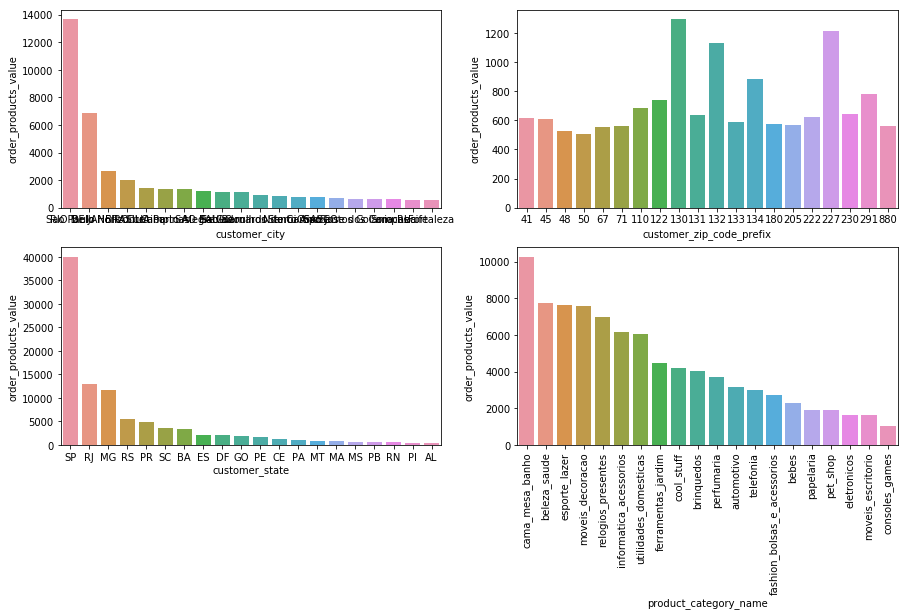

In [179]:
#Lets visuzalize some categorical variables
fig, ax =plt.subplots(nrows=2,ncols=2,figsize=(15,8))
city_df = df.groupby(by=['customer_city'])['order_products_value'].size().sort_values(ascending=False).reset_index().head(20)
sns.barplot(x='customer_city',y='order_products_value',data=city_df,ax=ax[0,0])
plt.xticks(rotation=90);

zip_df = df.groupby(by=['customer_zip_code_prefix'])['order_products_value'].size().sort_values(ascending=False).reset_index().head(20)
sns.barplot(x='customer_zip_code_prefix',y='order_products_value',data=zip_df,ax=ax[0,1])
plt.xticks(rotation=90);

state_df = df.groupby(by=['customer_state'])['order_products_value'].size().sort_values(ascending=False).reset_index().head(20)
sns.barplot(x='customer_state',y='order_products_value',data=state_df,ax=ax[1,0])
plt.xticks(rotation=90);

product_df = df.groupby(by=['product_category_name'])['order_products_value'].size().sort_values(ascending=False).reset_index().head(20)
sns.barplot(x='product_category_name',y='order_products_value',data=product_df,ax=ax[1,1])
plt.xticks(rotation=90);

In [180]:
#customer_city is the lower granular level. Lets keep that and remove other geo features
df = df.drop(labels=['customer_state','customer_zip_code_prefix'],axis=1)
print(df.shape)

(97586, 14)


In [181]:
#With customer city and product_category_name model overfits. Based on experiments dropping the below fields
#df = df.drop(labels=['product_category_name'],axis=1)
df = df.drop(labels=['customer_city'],axis=1)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97586 entries, 0 to 99999
Data columns (total 13 columns):
order_products_value          97586 non-null float64
order_freight_value           97586 non-null float64
order_items_qty               97586 non-null int64
order_sellers_qty             97586 non-null int64
order_purchase_timestamp      97586 non-null datetime64[ns]
product_category_name         97586 non-null object
product_name_lenght           97586 non-null int64
product_description_lenght    97586 non-null int64
product_photos_qty            97586 non-null int64
review_score                  97586 non-null int64
order_estimated_days          97586 non-null int64
order_delivered_days          97586 non-null int64
review_answer_days            97586 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(9), object(1)
memory usage: 10.4+ MB


In [183]:
df = pd.get_dummies(df)
df.shape

(97586, 83)

In [184]:
df.set_index('order_purchase_timestamp',inplace=True)
df.index=[x.date() for x in df.index]

In [185]:
group_df = df.groupby(df.index).sum()

(array([736238., 736330., 736420., 736511., 736603., 736695., 736785.,
        736876., 736968.]), <a list of 9 Text xticklabel objects>)

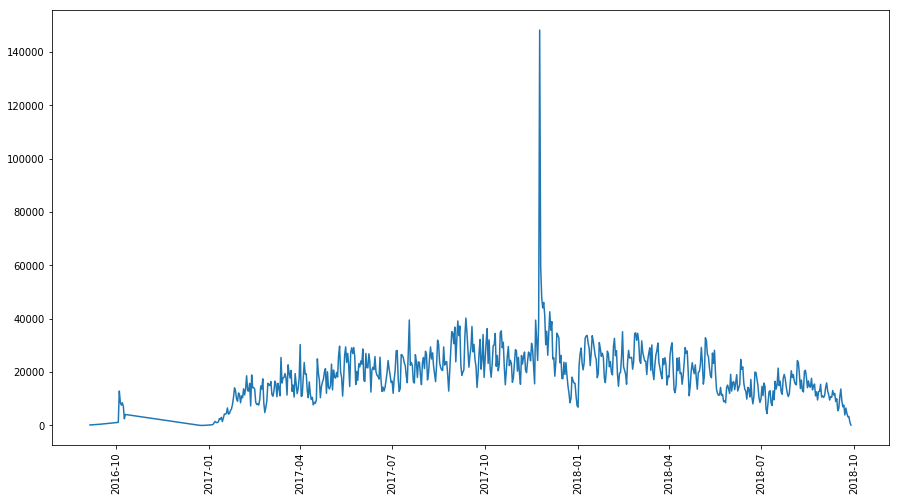

In [186]:
plt.figure(figsize=(15,8))
group_df['order_products_value'].plot()
plt.xticks(rotation=90)

In [187]:
#There are some missing values. Need to derive a logic to find index from where no missing values are available

group_df.index=pd.to_datetime(group_df.index)
group_df['lag_index']=group_df.index
group_df['lag_index']=group_df['lag_index'].shift(-1)
group_df['lag_index'].fillna(method='ffill',inplace=True)
group_df['lag_days']=(group_df['lag_index']-group_df.index).dt.days
group_df.head(15)

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,order_estimated_days,order_delivered_days,...,product_category_name_portateis_casa_forno_e_cafe,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas,lag_index,lag_days
2016-09-05,179.00,17.19,1,1,28,1237,4,1,51,56,...,0,0,0,0,0,0,0,0,2016-09-15,10
2016-09-15,449.90,21.25,4,2,68,2072,2,2,42,117,...,0,0,0,0,0,0,0,0,2016-10-03,18
2016-10-03,1145.06,186.26,11,9,496,9303,19,28,424,241,...,0,1,0,0,0,0,0,1,2016-10-04,1
2016-10-04,12876.75,1562.89,79,89,3614,68077,163,288,4040,1860,...,0,1,0,0,0,2,0,4,2016-10-05,1
2016-10-05,8759.03,1572.12,72,105,2735,47589,133,220,3242,1202,...,0,0,0,0,0,3,2,0,2016-10-06,1
2016-10-06,7602.48,1122.46,62,65,2658,45756,170,224,3142,1138,...,0,3,0,0,0,3,2,3,2016-10-07,1
2016-10-07,8477.48,1138.75,60,54,2646,51045,147,205,2956,878,...,0,0,0,0,0,3,1,1,2016-10-08,1
2016-10-08,7163.78,1107.64,50,48,2202,36506,132,181,2518,723,...,0,0,0,0,0,0,0,3,2016-10-09,1
2016-10-09,2482.04,558.23,29,37,1329,19622,59,104,1357,332,...,0,0,0,0,0,0,0,2,2016-10-10,1
2016-10-10,4107.67,851.20,47,44,2065,43344,120,152,2336,824,...,0,0,0,0,0,1,1,1,2016-12-23,74


In [188]:
#group_df.corr()
group_df['row_freq']=[sum(group_df['lag_days'][i:])/len(group_df['lag_days'][i:]) for i in group_df.index]
group_df = group_df[group_df['row_freq']<=1]
group_df.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,order_estimated_days,order_delivered_days,...,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas,lag_index,lag_days,row_freq
2017-01-04,258.99,33.94,2,2,77,1373,5,10,74,18,...,1,0,0,0,0,0,0,2017-01-05,1,0.998420
2017-01-05,492.00,388.85,41,41,2282,67511,53,202,1444,446,...,0,0,0,0,0,0,0,2017-01-06,1,0.998418
2017-01-06,1134.38,88.87,5,5,240,4045,8,24,194,37,...,0,0,0,0,0,1,0,2017-01-07,1,0.998415
2017-01-07,1478.89,152.78,8,6,311,3782,16,19,249,105,...,1,0,0,0,0,0,0,2017-01-08,1,0.998413
2017-01-08,1046.67,195.99,7,6,284,5280,16,20,234,66,...,0,0,0,0,0,0,0,2017-01-09,1,0.998410


In [189]:
#group_df = group_df.loc['2017-01-04':]

In [190]:
#group_df.head()

In [191]:
group_df = group_df.drop(labels=['lag_index','lag_days','row_freq'],axis=1)

In [192]:
group_df.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,order_estimated_days,order_delivered_days,...,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_portateis_casa_forno_e_cafe,product_category_name_relogios_presentes,product_category_name_seguros_e_servicos,product_category_name_sinalizacao_e_seguranca,product_category_name_tablets_impressao_imagem,product_category_name_telefonia,product_category_name_telefonia_fixa,product_category_name_utilidades_domesticas
2017-01-04,258.99,33.94,2,2,77,1373,5,10,74,18,...,0,0,0,1,0,0,0,0,0,0
2017-01-05,492.00,388.85,41,41,2282,67511,53,202,1444,446,...,0,7,0,0,0,0,0,0,0,0
2017-01-06,1134.38,88.87,5,5,240,4045,8,24,194,37,...,0,0,0,0,0,0,0,0,1,0
2017-01-07,1478.89,152.78,8,6,311,3782,16,19,249,105,...,0,0,0,1,0,0,0,0,0,0
2017-01-08,1046.67,195.99,7,6,284,5280,16,20,234,66,...,0,0,0,0,0,0,0,0,0,0


(array([2449, 2453, 2466, 2479, 2492, 2506, 2518, 2531, 2545, 2548],
       dtype=int64), <a list of 10 Text xticklabel objects>)

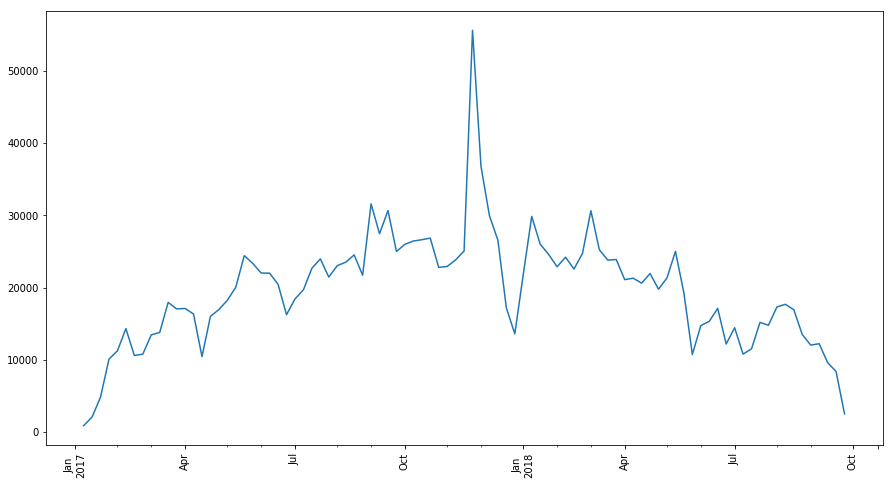

In [193]:
#print(group_df.resample('W').sum().head())
#print(group_df.resample('W').mean().head())
group_df = group_df.resample('W').mean()
plt.figure(figsize=(15,8))
group_df['order_products_value'].plot()
plt.xticks(rotation=90)

In [194]:
actual_collength = len(group_df.columns)
scaler = MinMaxScaler()
group_df1 = scaler.fit_transform(group_df.values)
group_df1 = pd.DataFrame(group_df1,columns=group_df.columns)

In [195]:
#Function to create timestep lag records. No_lags parameter holds the timesteps
def create_lags(data, no_lags):
    columns = data.columns
    for i in range(1, no_lags+1):
        for col in columns:
            data[col+'+'+str(i)] = data[col].shift(-i)
    return data

In [196]:
lag_value=3
lagdata = create_lags(group_df1.copy(),lag_value)
lagdata.head()

,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,product_name_lenght,product_description_lenght,product_photos_qty,review_score,order_estimated_days,order_delivered_days,...,product_category_name_perfumaria+3,product_category_name_pet_shop+3,product_category_name_portateis_casa_forno_e_cafe+3,product_category_name_relogios_presentes+3,product_category_name_seguros_e_servicos+3,product_category_name_sinalizacao_e_seguranca+3,product_category_name_tablets_impressao_imagem+3,product_category_name_telefonia+3,product_category_name_telefonia_fixa+3,product_category_name_utilidades_domesticas+3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008008,0.000000,0.000000,0.015708,0.007113,...,0.189655,0.062500,0.333333,0.014210,0.0,0.0,0.2,0.136364,0.454545,0.135802
1,0.021819,0.017474,0.008936,0.017888,0.008875,0.000000,0.020233,0.006244,0.038162,0.017747,...,0.155172,0.125000,0.000000,0.058615,0.0,0.0,0.6,0.245455,0.545455,0.117284
2,0.072206,0.066461,0.065696,0.059909,0.061709,0.055951,0.078080,0.070989,0.132986,0.051535,...,0.120690,0.166667,0.000000,0.040853,0.0,0.2,0.6,0.327273,0.636364,0.240741
3,0.168247,0.117467,0.121614,0.123509,0.112766,0.145891,0.127683,0.132740,0.231235,0.103889,...,0.068966,0.208333,0.000000,0.009769,0.0,0.0,0.0,0.381818,0.909091,0.135802
4,0.189293,0.156551,0.156457,0.166383,0.152430,0.184523,0.164291,0.177728,0.268436,0.123334,...,0.045977,0.083333,0.000000,0.045293,0.0,0.0,0.6,0.309091,0.454545,0.185185


In [197]:
def prep_traindata(data,tgt,lag_value):
    y_data = data[tgt+'+'+str(lag_value)]
    X_data = data.iloc[:,:group_df1.shape[1]*lag_value]
    X_data.dropna(inplace=True)
    y_data.dropna(inplace=True)
    test_data = X_data.iloc[-1,:]
    X_data = X_data.iloc[:-1,:]
    return X_data, y_data, test_data
    

In [198]:
X_data, y_data, test_data = prep_traindata(lagdata, 'order_products_value',lag_value)
print(X_data.shape, y_data.shape)
X_values = X_data.values
y_values = y_data.values
test_values = test_data.values

(88, 246) (88,)


In [199]:
def train_test_split(X_values, y_values, prop):
    train_size = int(X_values.shape[0]*prop)
    train_X, train_y = X_values[:train_size,:], y_values[:train_size,:]
    val_X, val_y = X_values[train_size:,:], y_values[train_size:,:]
    return train_X, train_y, val_X, val_y

In [200]:
y_values = y_values.reshape((y_values.shape[0],1))
train_X, train_y, val_X, val_y = train_test_split(X_values, y_values, 0.8)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(70, 246) (70, 1) (18, 246) (18, 1)


In [201]:
train_X = train_X.reshape((train_X.shape[0],lag_value,int(train_X.shape[1]/lag_value)))
val_X = val_X.reshape((val_X.shape[0],lag_value,int(val_X.shape[1]/lag_value)))
test_values = test_values.reshape((test_values.shape[0],-1))
test_values = test_values.reshape((test_values.shape[1],lag_value,int(test_values.shape[0]/lag_value)))
print(train_X.shape, val_X.shape, test_values.shape)

(70, 3, 82) (18, 3, 82) (1, 3, 82)


Train on 70 samples, validate on 18 samples
Epoch 1/50
70/70 [==============================] - 3s 49ms/step - loss: 0.0283 - val_loss: 0.0055
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0067
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0167
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0128
Epoch 5/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0457
Epoch 6/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0122

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 8/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 9/50
70/70 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss:

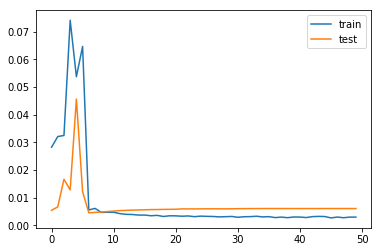

In [202]:
seed(5)
model = Sequential()
model.add(Bidirectional(LSTM(50, kernel_initializer='lecun_normal',recurrent_dropout=0.2,input_shape=(train_X.shape[1], train_X.shape[2]))))
#model.add(Dropout(0.20))
#model.add(Bidirectional(LSTM(30, kernel_initializer='lecun_normal', recurrent_dropout=0.2)))
#model.add(Dropout(0.20))
#model.add(Dense(12,activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

lrcallback = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1E-10)
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min')
history = model.fit(train_X, train_y, epochs=50, batch_size=4, validation_data=(val_X, val_y), verbose=1, shuffle=False,
                   callbacks=[lrcallback])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Order products value for next week 2018-10-07 is:  [5236.49776464]

RMSE score:  3271.0408058776234
RMSE score for mean forecast:  7258.279690757378
RMSE score for validation set:  4276.729515596799
RMSE score for validation set with mean forecast:  7944.395891689276


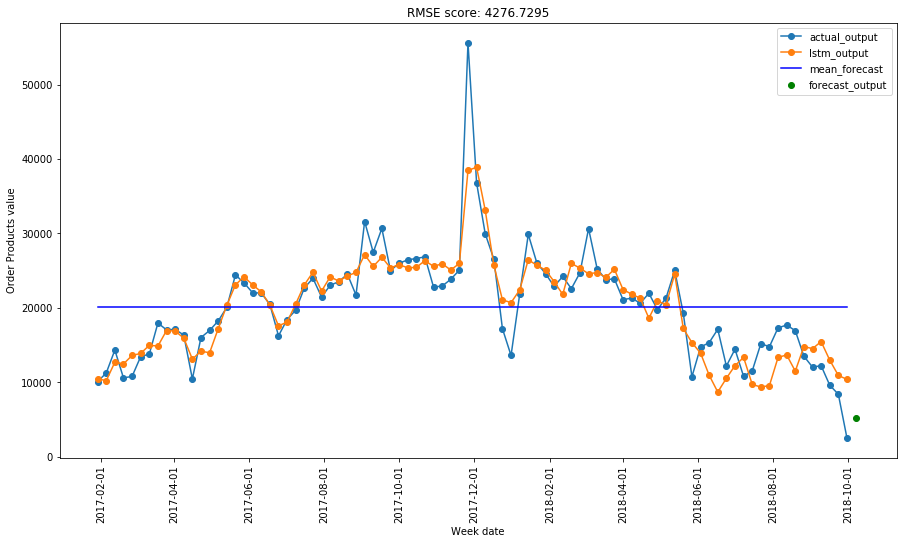

In [203]:
# Get val_loss value from the checkpoint model name
def get_loss(names):
    basename = os.path.splitext(names)[0]
    loss = basename.split('-')[1]
    return loss

pred = scaler.inverse_transform(np.concatenate((model.predict(val_X), val_X.reshape((val_X.shape[0], -1))), axis=1)[:,:actual_collength])[:,0]

actual = scaler.inverse_transform(np.concatenate((val_y, val_X.reshape((val_X.shape[0], -1))), axis=1)[:,:actual_collength])[:,0]

train_pred = scaler.inverse_transform(np.concatenate((model.predict(train_X), train_X.reshape((train_X.shape[0], -1))), axis=1)[:,:actual_collength])[:,0]

train_actual = scaler.inverse_transform(np.concatenate((train_y, train_X.reshape((train_X.shape[0], -1))), axis=1)[:,:actual_collength])[:,0]

avalues = np.concatenate((train_actual,actual))
pvalues = np.concatenate((train_pred,pred))


forecast = scaler.inverse_transform(np.concatenate((model.predict(test_values), test_values.reshape((test_values.shape[0], -1))), axis=1)[:,:actual_collength])[:,0]

yearsFmt = mdates.DateFormatter('%Y-%m-%d')
next_week =(group_df.index[-1]+datetime.timedelta(days=7)).strftime ('%Y-%m-%d')

print('Order products value for next week',next_week,'is: ',scaler.inverse_transform(np.concatenate((model.predict(test_values), test_values.reshape((test_values.shape[0], -1))), axis=1)[:,:actual_collength])[:,0])
print()
print('RMSE score: ', np.sqrt(mean_squared_error(avalues,pvalues)))

mean_forecast = [np.mean(avalues)]*len(avalues)
mean_forecast1 = [np.mean(avalues)]*len(actual)

print('RMSE score for mean forecast: ', np.sqrt(mean_squared_error(avalues,mean_forecast)))

print('RMSE score for validation set: ', np.sqrt(mean_squared_error(actual,pred)))
print('RMSE score for validation set with mean forecast: ', np.sqrt(mean_squared_error(actual,mean_forecast1)))

fig,ax1 = plt.subplots(figsize=(15,8))
ax1.plot(group_df.index[lag_value:], np.concatenate((train_actual,actual)), label='actual_output',marker='o')
ax1.plot(group_df.index[lag_value:], np.concatenate((train_pred,pred)), label='lstm_output',marker='o')
ax1.plot(group_df.index[lag_value:], mean_forecast, label='mean_forecast',color='blue')
ax1.scatter(x=next_week,y=forecast, label='forecast_output', color='green')
ax1.xaxis.set_major_formatter(yearsFmt)
plt.xticks(rotation=90)
plt.xlabel('Week date')
plt.ylabel('Order Products value')
plt.title('RMSE score: {:.4f}'.format(np.sqrt(mean_squared_error(actual,pred))))
plt.legend()
plt.savefig('prediction_plot.jpg')
plt.show()